# PAOS

This notebook demonstrates the basic functionality of PAOS.

Select the desired example configuration desired below

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os, sys, time
from pathlib import Path

# Add to PYTHONPATH the path to local libraries
paospath = "~/git/PAOS"
if not os.path.expanduser(paospath) in sys.path:
    sys.path.append( os.path.expanduser(paospath) )

import paos

## Inputs

Define lens file to use

In [2]:
OpticalPrescription = 'PAOS_Input_TEL_v04'
#OpticalPrescription = 'PAOS_Input_TEL_OGSE_v04'
OpticalPrescription = 'PAOS_TEL_COM_CH0_v02'

OpticalPrescriptionFile = os.path.join(paospath, 'lens data', ''.join([OpticalPrescription, '.xlsx']))

In [3]:
# Parse lens file
pup_diameter, general, fields, opt_chain = paos.ParseConfig(OpticalPrescriptionFile)

## Ray tracing
Implement a full raytracing. For diagnostic purposes.

In [4]:
paos.raytrace(fields['0'], opt_chain)

S02 - LOS tilt        y:  0.000mm ut: 1.745e-03 rad x:  0.000mm us:  0.000 rad
S03 - Move to M1      y:500.000mm ut: 1.745e-03 rad x:  0.000mm us:  0.000 rad
S04 - M1              y: 49.136mm ut: 4.294e-01 rad x:  0.000mm us:  0.000 rad
S05 - M2              y: 24.559mm ut:-1.846e-02 rad x:  0.000mm us:  0.000 rad
S06 - FOCUS           y: 19.855mm ut:-1.846e-02 rad x:  0.000mm us:  0.000 rad
S07 - M3              y: 19.855mm ut: 9.637e-02 rad x:  0.000mm us:  0.000 rad
S08 - Ray Centering   y: -0.018mm ut:-6.050e-05 rad x:  0.000mm us:  0.000 rad
S09 - Move to M4      y: -0.006mm ut:-6.050e-05 rad x:  0.000mm us:  0.000 rad
S10 - x tilt – M4     y: -0.009mm ut:-1.124e+00 rad x:  0.000mm us:  0.000 rad
S11 - M4              y: -0.009mm ut: 1.124e+00 rad x:  0.000mm us:  0.000 rad
S12 - -x tilt – M4    y:  0.000mm ut: 6.050e-05 rad x:  0.000mm us:  0.000 rad
S13 - exit pupil      y:  0.064mm ut: 6.050e-05 rad x:  0.000mm us:  0.000 rad
S15 - M7              y:  0.014mm ut:-2.095e-04 rad 

## Physical optics propagation

Run the POP

In [5]:
start_time = time.time()
print('Start POP...')

retval = paos.run(pup_diameter, 1.0e-6 * general['wavelength'], general['grid size'], general['zoom'],
                 fields['0'], opt_chain)

end_time = time.time()
print('POP completed in {:6.1f}s'.format(end_time-start_time))

Start POP...
POP completed in    1.1s


## Plot results

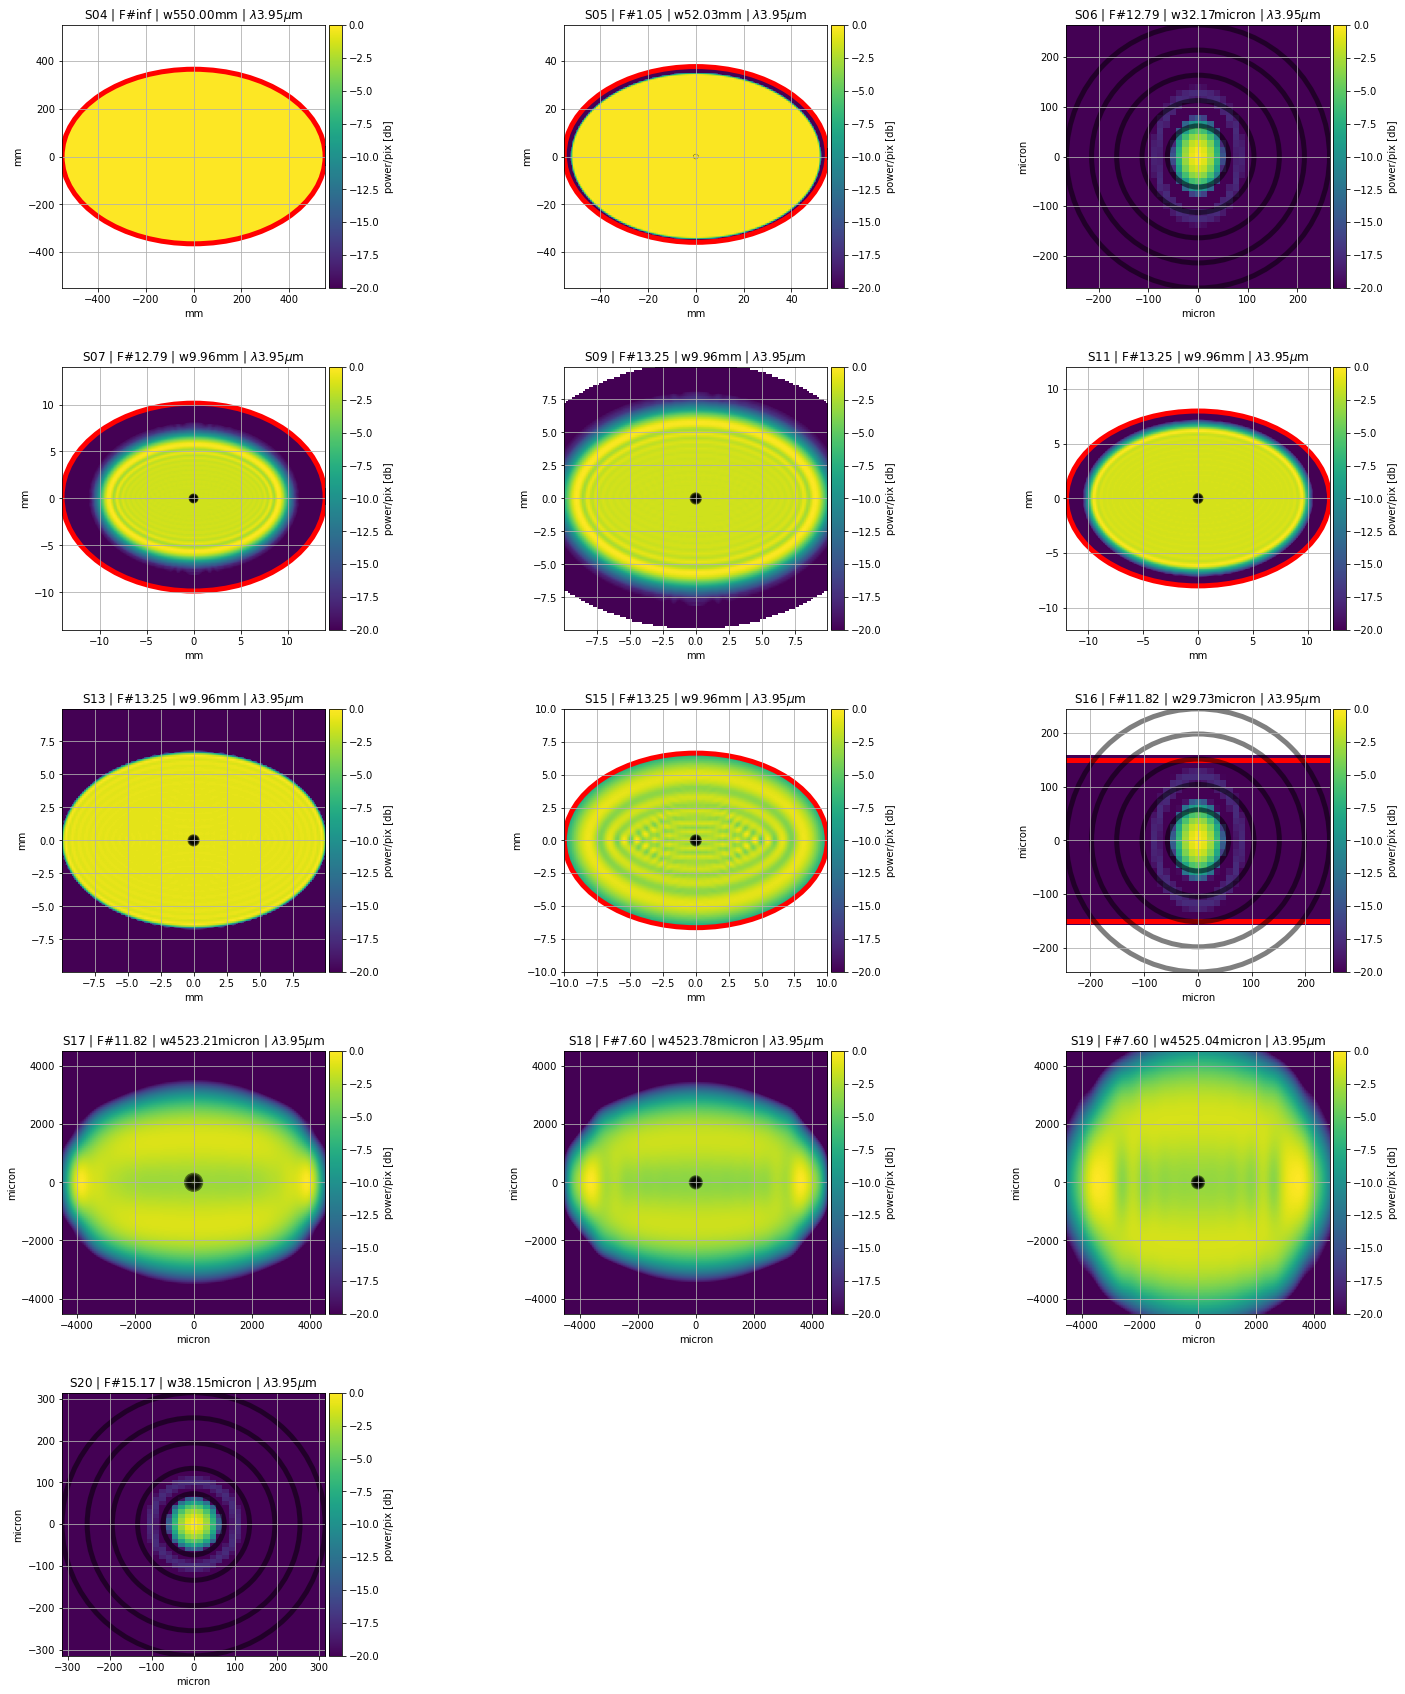

In [6]:
plots_dir = './plots'
Path(plots_dir).mkdir(parents=True, exist_ok=True)
figname = os.path.join(plots_dir, ''.join([OpticalPrescription, '_', str(1.0e-6 * general['wavelength']), '.png']))

paos.plot_pop(retval, ima_scale='log', ncols=3, figname=figname)

# Run multiple POP simulations in parallel

This section demonstrates performing multiple POP simulations using parallel threads.

In [7]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# Run the POP at two different wavelengths.

start_time = time.time()
print('Start POP in parallel...')

n_jobs = 2
wavelengths = [2.0, 3.0]  #microns

ret = Parallel(n_jobs=n_jobs)(delayed(paos.run)(pup_diameter,
                                                1.0e-6 * wl,
                                                general['grid size'],
                                                general['zoom'],
                                                fields['0'], 
                                                opt_chain
                                                ) 
                                                for wl in tqdm(wavelengths))

end_time = time.time()
print('Parallel POP completed in {:6.1f}s'.format(end_time-start_time))

Start POP in parallel...



Parallel POP completed in    4.6s


# Save results

This section demonstrates saving your results. 
The results are saved in .h5 format.

The saving routine are very flexible: you can either 
- save everything in your results (wfo, dx, dx, apertures...)
- or just a selection of things that you need (just the wfo, or whatever list of things)

In [8]:
saving_dir = './data'
Path(saving_dir).mkdir(parents=True, exist_ok=True)

1) This is how to save your output if you simulated just one POP realisation. 

In [9]:
HDF5FileName = os.path.join(saving_dir, ''.join([OpticalPrescription, '_everything.h5']))
paos.save_output(retval, HDF5FileName, overwrite=True, verbose=True)

#HDF5FileName = os.path.join(saving_dir, ''.join([OpticalPrescription, '_selection.h5']))
#save_output(retval, HDF5FileName, keys_to_keep=['wfo', 'dx'], overwrite=True, verbose=False)

saving ./data/PAOS_TEL_COM_CH0_v02_everything.h5 started...
removing old file
saving S04
saving S05
saving S06
saving S07
saving S09
saving S11
saving S13
saving S15
saving S16
saving S17
saving S18
saving S19
saving S20
saving ended.


2) This is how to save your output if you simulated more than one POP realisation. 

In [10]:
# Since we just ran the POP at two different wavelengths, 
# let's use them to unequivocally tag the two simulations.

group_tags = list(map(str, wavelengths))

In [11]:
HDF5FileName = os.path.join(saving_dir, ''.join([OpticalPrescription, '_everything_cube.h5']))
paos.save_datacube(ret, HDF5FileName, group_tags, overwrite=True, verbose=True)

#HDF5FileName = os.path.join(saving_dir, ''.join([OpticalPrescription, '_selection_cube.h5']))
#save_datacube(ret, HDF5FileName, group_tags,
#              keys_to_keep=['aperture', 'dx', 'dy'], overwrite=True, verbose=False)              

saving ./data/PAOS_TEL_COM_CH0_v02_everything_cube.h5 started...
removing old file
saving group <HDF5 group "/2.0" (0 members)>
saving group <HDF5 group "/3.0" (0 members)>
saving ended.
